Having explored how MHA can be used inside encoder to generate meaningful embeddings that could be used for classification (`mha_classifier.ipynb`) it only seems right to explore how it works not only inside Encoder-only architectures, but Encoder-Decoder as well. Hence, this notebook is going to be dedicated to coding up the whole transformer from scratch. Just a little reminder, here's how the architecture of the Transformer looks:

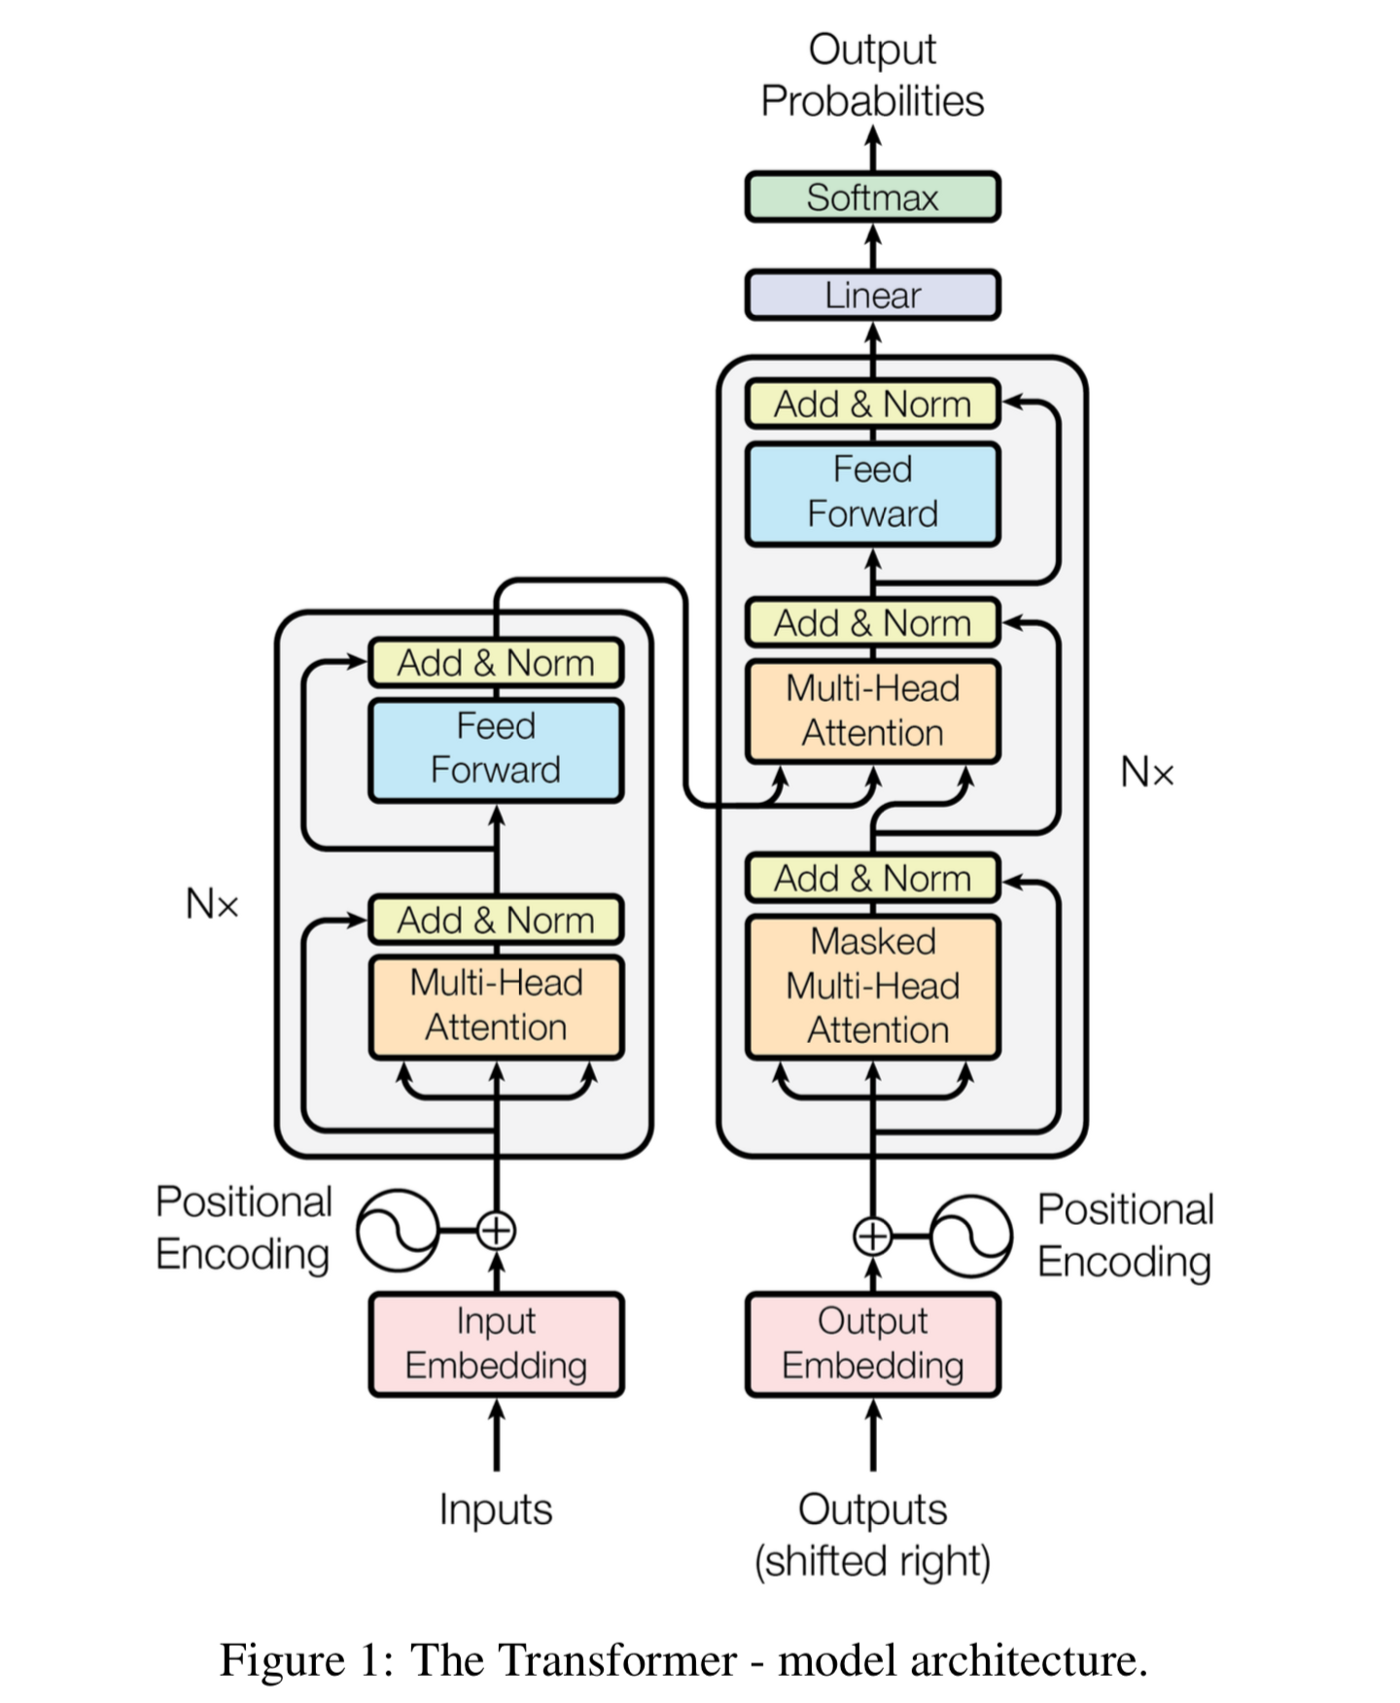

#### Preparing the dataset
For the demo we can load up the wikitext dataset from Hugginface. Then we'll build a preprocessing pipeline using tokenizers and then tokenize our sequence by training the Unigram tokenizer.

In [1]:
from datasets import load_dataset
import torch

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")
sample_size = 10
dataset.select(torch.randperm(len(dataset))[:sample_size])['text']

[' = = Communist Party period = = \n',
 ' With the " four three @-@ quarter " formation Wales became Home International Champions for the first time in 1893 ; in the process winning the Triple Crown . Wales next won the Championship in 1900 , heralding the first " golden age " of Welsh rugby which was to last until 1911 . They won two more Triple Crowns in 1902 and 1905 , and were runners up in 1901 , 1903 and 1904 . \n',
 '',
 ' The convoy reached a position 65 nautical miles ( 120 km ; 75 mi ) off St Nazaire at 21 : 00 and changed course toward the estuary , leaving Atherstone and Tynedale as a sea patrol . The convoy adopted a new formation with the MGB and two torpedo MLs in the lead , followed by Campbeltown . The rest of the MLs formed two columns on either side and astern of the destroyer , with the MTB bringing up the rear . The first casualty of the raid was ML 341 , which had developed engine trouble and was abandoned . At 22 : 00 the submarine Sturgeon directed her navigatio

Next step is building a normalization pipeline for the Unigram tokenizer, a pretty good model that is aimed to build representations of words based off the general joint probability distribution of all possible subsequences:

In [2]:
from tokenizers import (
    decoders,
    models,
    Regex,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

# initializing the tokenizer
tokenizer = Tokenizer(models.Unigram())

# normilising pipeling
tokenizer.normalizer = normalizers.Sequence(
    [
        # replace quotation marks with their universal standard
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),

        # one of the best normalization technique that brings
        # all symbols to their best compatible analogue, e.g.
        # ① -> 1 or ™ -> T M 
        normalizers.NFKD(),

        # additional normalization technique that does á -> a
        normalizers.StripAccents(),

        # replace two or more spaces with a single one
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

Now we're ready to set up the training of the Unigram tokenizer preliminary initializing special tokens, that are needed later for a better dictionary representation:

In [3]:
special_tokens = ["<sep>", "<unk>", "<pad>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=32000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(dataset['text'], trainer=trainer)

After running the training we can test the tokenizer on the arbitrary sequence:

In [4]:
enc = tokenizer.encode("The goalkeeper's hit 9 times.")
print(enc.tokens, enc.ids)

['The ', 'go', 'al', 'keep', 'er', "'s ", 'hit ', '9 ', 'time', 's', '.'] [163, 2069, 291, 25105, 269, 17, 962, 422, 11085, 43, 166]


After creating a normalization pipeline and training our tokenizer we can create a seperate dataset on top of the wikiset dataset that handles truncations and additional preprocessing (e.g. replacing OOV tokens with \<unk\>):

In [5]:
from torch.utils.data import Dataset
import torch

textual_params = {
    'max_seq': 512-2 # adding minus two in order to acount for <s> tokens
}

def preprocess(tokenizer, token: str):
    """  
    Preprocessses each token with a corresponding ID from the vocabulary
    """
    token2id = tokenizer.token_to_id(token)
    return tokenizer.token_to_id('<unk>') if token2id is None else \
        tokenizer.token_to_id('<sep>') if token == ' ' else token2id

def pad_trunc_sequence(seq: list) -> list:
    """ 
    Adds <s> in the beggining and </s> in the end.
    Also adds pad tokens to the sequence if it has fewer tokens than
    maximum sequence length. Otherwise truncates it. 
    """
    if len(seq) < textual_params['max_seq']:
        seq += [tokenizer.token_to_id('</s>')]
        seq += [tokenizer.encode('<pad>').ids[0] \
                           for _ in range(textual_params['max_seq'] - len(seq) + 1)]
        return [tokenizer.token_to_id('<s>')] + seq
    else:
        return [tokenizer.token_to_id('<s>')] + \
            seq[:textual_params['max_seq']] + [tokenizer.token_to_id('</s>')]

class texts2id_dataset(Dataset):
    def __init__(self, ds):
        """ 
        - ds: datasets.arrow_dataset.Dataset
            - Expects a dataset of items with the key of "text"
            corresponding to text sequences
        """
        self.texts = ds['text']
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        sequences = []
        
        # check whether index is single and thus we have to iterate
        # over just one sequence rather than multiple ones
        iterated_sequences = [self.texts[index]] if isinstance(index, int) \
            else self.texts[index]
        for seq in iterated_sequences:
            tokens2ids = torch.tensor(pad_trunc_sequence([
                preprocess(tokenizer, text) for text in \
                    tokenizer.encode(seq).tokens
            ]),  dtype=torch.long)
            sequences.append(tokens2ids)

        return torch.vstack(sequences)
    
ds = texts2id_dataset(dataset)
ds[2:5]

tensor([[    3,     4,     2,  ...,     2,     2,     2],
        [    3,   968,   208,  ...,     2,     2,     2],
        [    3, 11828,   141,  ...,     2,     2,     2]])

#### Building an embedding module 
First step is creating an embedding module that will learn the most meaningful representation of words based on some vocabulary we've obtained after tokenization. For the sake of simplicity both token embeddings and positional embeddings are going to be learnable

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class Embedding(nn.Module):

    def __init__(self, vocab_size, embed_d, max_seq_len,
                 dropout=.01, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        # each word in vocabulary is going to get its 
        # vector representation
        self.max_seq_len = max_seq_len
        self.tokenEmbed = nn.Embedding(vocab_size,embed_d)
        self.posEmbed = nn.Embedding(self.max_seq_len,embed_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """ 
        Expects sequences of token indices
        """
        batch_size = x.shape[0]

        # expanding range [0, max_seq_len]=seq_range to 
        # [seq_range,seq_range,...,] tensor of batch_size
        pos = torch.arange(0, self.max_seq_len).expand(
            batch_size, self.max_seq_len
        )
        emb = self.tokenEmbed(x) + self.posEmbed(pos)
        return self.dropout(emb)

Having coded an Embedding layer we can now use it on the dataset of indices to sample an embedding for each token:

In [7]:
emb = Embedding(vocab_size=32000,embed_d=256,max_seq_len=512)
emb(ds[1])

tensor([[[-2.4676, -1.3420, -1.2740,  ...,  1.7485,  3.2005, -0.9141],
         [-1.8365, -3.0398, -2.0652,  ..., -0.8561,  1.0260,  1.2786],
         [-1.0790, -0.5399,  1.5500,  ...,  0.8775, -1.6456,  1.6233],
         ...,
         [ 0.4280,  1.0896,  1.7983,  ...,  2.0944, -0.8009, -1.8771],
         [ 1.1954, -0.8763, -0.3887,  ...,  2.7551,  0.7711,  1.0781],
         [ 0.9722, -0.6322, -0.3601,  ...,  2.0591,  0.5777,  2.2702]]],
       grad_fn=<MulBackward0>)

#### Coding up the MQA

Next we can move on to coding up an attention layer of the Transformer. Instead of MHA, we're going to be creating MQA (Multi-Query Attention) (https://arxiv.org/pdf/1911.02150) that has proven to yeild better results and is used in SOTA LLMs like Gemma (https://arxiv.org/pdf/2403.08295)

In [137]:
class MQA(nn.Module):

    def __init__(self, embed_d, max_seq_len, q_n, *args, **kwargs) -> None:
        """ 
        - embed_d: int
            - embedding dimensions
        - max_seq_len: int
            - maximum length of a sentence
        - q_n: int
            - number of Q heads
        """
        super().__init__(*args, **kwargs)
        self.max_seq_len = max_seq_len
        self.d = embed_d
        self.num_q = q_n
        self.outProj = nn.Linear(self.max_seq_len*self.num_q,self.max_seq_len,bias=False)
        self.Qs = nn.ModuleList([
            nn.Linear(self.d,self.d) for _ in range(self.num_q)
        ])
        self.K = nn.Linear(self.d,self.d)
        self.V = nn.Linear(self.d,self.d)

    def self_att(self, Q, K, V, mask=None):
        """ 
        Apply a single self-attention on a set of Q,K,V matrices
        """
        att_matrix = torch.einsum('bjk,bkl -> bjl', Q, K.permute(0, 2, 1))
        att_matrix = torch.softmax(att_matrix/self.d**.5, dim=-1)
        if mask is not None:
            att_matrix = att_matrix.masked_fill(mask == 0, float("-1e20"))
        return torch.einsum('bjk,bkl -> bjl',att_matrix,V)

    def forward(self, key, query, x, mask=None):
        K = self.K(key)
        V = self.V(x)
        Qs = torch.cat([
            self.self_att(q(query), K, V, mask) for q in self.Qs
        ], dim=1).permute(0,2,1)
        return self.outProj(Qs).permute(0,2,1)

Having coded up the MQA we can recreate a self-attention mechanism by applying MQA on the single embedding:

In [140]:
mqa = MQA(embed_d=256,max_seq_len=512,q_n=6)
x = emb(ds[1])
mqa(x, x, x), mqa(x, x, x).shape

(tensor([[[-0.0158,  0.0088, -0.0138,  ...,  0.0371,  0.0080,  0.0560],
          [ 0.0854, -0.0671, -0.0048,  ..., -0.1365, -0.0085, -0.1547],
          [ 0.1928, -0.1750, -0.0507,  ..., -0.2815,  0.0093, -0.3397],
          ...,
          [ 0.0324, -0.0350, -0.0197,  ..., -0.0729,  0.0120, -0.0893],
          [ 0.1106, -0.0994, -0.0119,  ..., -0.1629, -0.0142, -0.1795],
          [ 0.0664, -0.0590, -0.0157,  ..., -0.1272,  0.0056, -0.1543]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 513, 256]))

#### Encoder
First we build a so-called transformer block that is used in both encoder and decoder blocks of the Transformer

In [8]:
class TransformerBlock(nn.Module):

    def __init__(self, embed_d, num_heads=8,
                gamma=1, dropout=.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # MHA and LayerNorm blocks
        self.mha = nn.MultiheadAttention(embed_d,num_heads=num_heads,
                                         batch_first=True)
        self.norm = nn.LayerNorm(embed_d)

        # feed-forward block
        self.ff = nn.Sequential(
            nn.Linear(embed_d,embed_d*gamma),
            nn.GELU(),
            nn.Linear(embed_d*gamma,embed_d)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, k, q, x, mask=None):
        # get attention matrix
        att_matrix, _ = self.mha(k,q,x,
                                 attn_mask=mask,
                                # is_casual=True
                            )
        
        # resid connection on att_out and x (V matrix)
        x += att_matrix

        # apply LayerNorm and FF
        normed_x = self.norm(x)
        x_through_ff = self.ff(x)

        # resid connection on FF and first normed outputs
        x = normed_x + x_through_ff

        return self.dropout(self.norm(x))


After preparing a universal Transformer Block we can get down to coding up the Encoder block. The purpose of the encoder block is to serve as a "prior" knowledge of the environment. E.g. in the scope of the machine translation Encoder could serve as a dictionary of English words that a Decoder block later takes in order to pick the best token for translation.

In [9]:
class EncoderBlock(nn.Module):

    def __init__(self, embed_d, vocab_size, max_seq_len, 
                 num_heads=8, n_blocks=6, gamma=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.embedder = Embedding(vocab_size,embed_d,
                                  max_seq_len)
        self.transformerBlocks = nn.ModuleList([
            TransformerBlock(embed_d, num_heads, gamma) 
            for i in range(n_blocks)
        ])
    
    def forward(self, x):
        x = self.embedder(x)
        for block in self.transformerBlocks:
            x = block(x, x, x)
        return x

#### Decoder
Now the most interesting part - coding the decoder block of the Transformer. We'll have to create an expanded version of the transformer block, since the decoder block of the Transformer contains additional layers. To grasp its meaning in the scope of the Transformer Encoder-Decoder model I've also created a visually interpretable diagram that shows how they relate to each other in the context of the problem of machine translation:

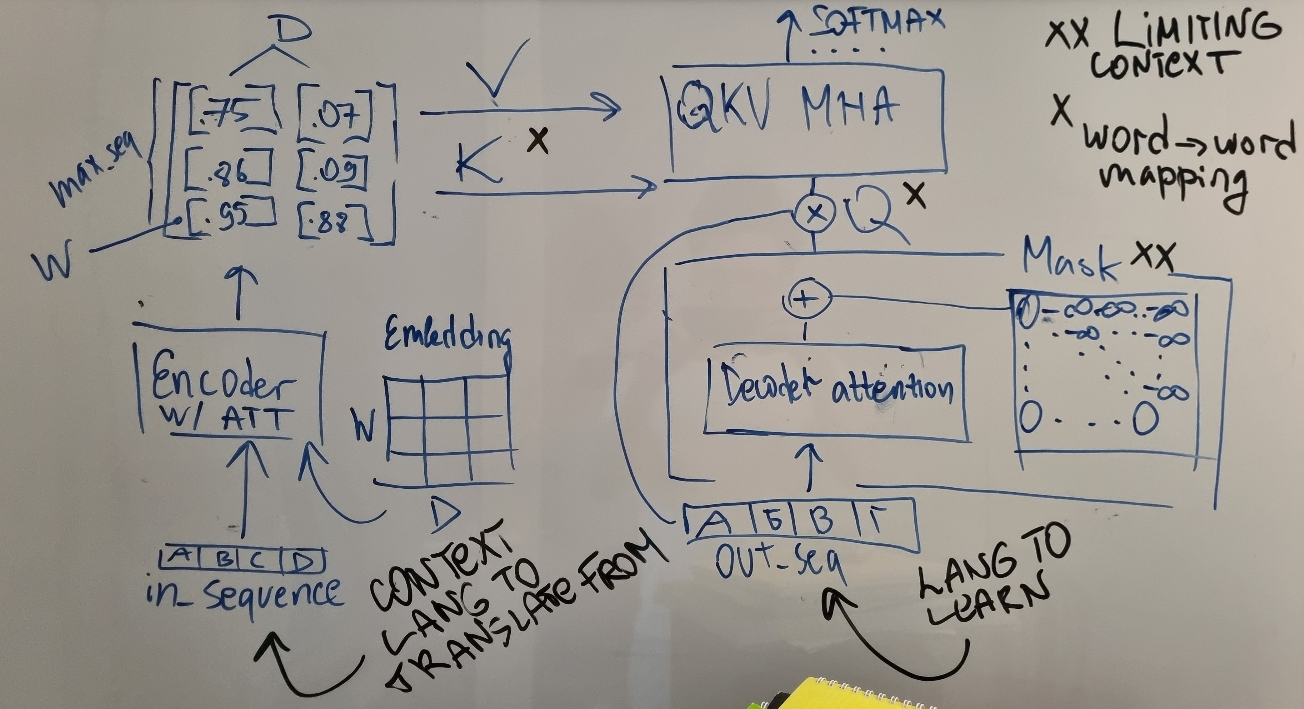

In [10]:
class TransformerBlockForDecoder(nn.Module):
    
    def __init__(self, embed_d, 
                 num_heads=8, gamma=4, dropout=.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mha = nn.MultiheadAttention(embed_d,num_heads=num_heads,batch_first=True)
        self.norm = nn.LayerNorm(embed_d)
        self.dropout = nn.Dropout(dropout)
        self.transformerBlock = TransformerBlock(
            embed_d,num_heads,gamma,dropout
        )

    def forward(self, k, q, x, mask):
        decoder_V_att, _ = self.mha(x,x,x,
                                 attn_mask=mask)
        decoder_V = self.dropout(self.norm(decoder_V_att + x))
        decoder_att_out = self.transformerBlock(k, q, decoder_V)
        return decoder_att_out 

class DecoderBlock(nn.Module):
    
    def __init__(self, embed_d, vocab_size, max_seq_len, 
                 num_heads=8, n_blocks=6, dropout=.2, gamma=4, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.embedder = Embedding(vocab_size, embed_d, 
                                  max_seq_len)
        
        self.decoderBlocks = nn.ModuleList([
            TransformerBlockForDecoder(
                embed_d,num_heads,gamma
            ) for i in range(n_blocks)
        ])
        self.dropout= nn.Dropout(dropout)
    
    def forward(self, x, enc_output, mask):
        x = self.dropout(self.embedder(x))
        for block in self.decoderBlocks:
            x = block(enc_output, x, enc_output, mask)
        return x

#### Building the transformer
This concludes the build of preliminary modules with which we're able to build the transformer network

In [11]:
class Transformer(nn.Module):

    def __init__(self, embed_d, vocab_size, target_vocab_size,
                 max_seq_len, num_heads, num_enc_blocks, num_dec_blocks, 
                 gamma=4, dropout=.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.encoder = EncoderBlock(embed_d,vocab_size,
                                    max_seq_len,
                                    num_heads,num_enc_blocks,
                                    gamma)
        self.decoder = DecoderBlock(embed_d,
                                    target_vocab_size,
                                    max_seq_len,
                                    num_heads,num_dec_blocks,
                                    gamma=gamma)
        self.mha_heads = num_heads
        self.fc_out = nn.Linear(embed_d,target_vocab_size)

    def make_target_mask(self, target):
        """ 
        Returns triangular matrix with elements above the
        main diagonal inside batches being 0
        """
        batch_size, mask_len = target.shape
        mask = torch.tril(torch.ones(
            mask_len,mask_len
        )).expand(self.mha_heads,mask_len,mask_len)[0]
        return mask
    
    def forward(self, inp, out):
        mask = self.make_target_mask(out)
        enc_out = self.encoder(inp)
        dec_out = self.decoder(out, enc_out, mask)
        return F.softmax(self.fc_out(dec_out), dim=-1)

Now we can apply the model to seq2seq problems, with the Encoder-Decoder architecutre returning a vector of probability distribution of each word inside dictionary for each of the following positions in the sentence, length of wich we've provided in `max_seq_len`:

In [30]:
src = ds[5]
target = ds[3]

model = Transformer(embed_d=256,
                    vocab_size=32000,
                    target_vocab_size=32000,
                    max_seq_len=512,
                    num_enc_blocks=6,
                    num_dec_blocks=6,
                    gamma=4,
                    num_heads=8)
model(src, target).shape

torch.Size([1, 512, 32000])

In [38]:
from textwrap import TextWrapper
from IPython.display import display, Markdown

wrapper = TextWrapper(width=50)

def decode_transformer_output(trans_out, tokenizer, src, target):
    src, target = tokenizer.decode_batch(src.tolist())[0], \
        tokenizer.decode_batch(target.tolist())[0]
    src, target = '\n'.join(wrapper.wrap(src)), \
        '\n'.join(wrapper.wrap(target))

    output_text = f"#### Contextually aware output for new sequence: \n {src} \n"
    output_text += f"#### New sequence to learn from: \n {target} \n"

    trans_out = torch.argmax(trans_out, dim=-1)
    decoded_batch = '\n'.join(
        wrapper.wrap(tokenizer.decode_batch(
        trans_out.tolist(), skip_special_tokens=False)[0].replace(r'\s{2}|\#', ' '))
    )
    output_text += f"#### Transformer output: \n {decoded_batch}"

    return output_text

with torch.no_grad():
    model.eval()
    out = model(src, target)
    display(Markdown(decode_transformer_output(out, tokenizer, src, target)))
    model.train()

#### Contextually aware output for new sequence: 
  It  met with  positive  sales  in Japan  , and
was praised by  both  Japanese  and  western
critics  . After  release ,  it  received
downloadable  content  , along with  an  expanded
edition  in November  of that year  . It was also
adapted  into  manga  and  an original  video
animation  series  . Due to  low  sales of
Valkyria  Chronicles II  ,  Valkyria  Chronicles
III  was not  localized  , but  a  fan
translation  compatible  with  the game 's
expanded  edition  was released in  2014 .  Media
. Vision  would  return to the  franchise  with
the  development of  Valkyria  :  Az ure
Revolution  for  the PlayStation  4  . 
#### New sequence to learn from: 
  S en j o no Valkyria 3  :  Un recorded
Chronicles  ( Japanese :  戦 場 の ウ ァ ル キ ュ リ ア 3  ,
lit .  Valkyria  of the  Battle field  3 )  ,
commonly  referred to as  Valkyria  Chronicles III
outside  Japan  , is a  tactical  role @-@ play
ing  video game  developed by  Seg a  and  Media .
Vision  for  the PlayStation  Portable  . Released
in January  2011  in Japan  , it is  the third
game  in the  Valkyria  series  .  Em ploy ing
the same  fusion  of  tactical  and  real  @-@
time  gameplay  as its  predecessors  ,  the story
runs  parallel  to  the first game  and  follows
the  "  Name less  " , a  penal military  unit
serving  the  nation  of  Galli a  during the
Second  Euro p an  War  who  perform  secret
black  operations  and  are  pit ted  against  the
Imperial  unit  "  Cal ama ty  Raven  " . 
#### Transformer output: 
 @-@ yard line .  five months  tudes   Ibari  ator
prescribed  his mother   Eventually  fast bowler
sperm ddling  4 @.@ 9 m )  regular カ services
qualifying  would be  ascend 榮 cuisine  ill health
its release  agnificent  mm  obb 2012  broadside
storm  onym 4 @.@ 9 m )  Home Gray  Grand Rapids
the Red River  semifinal  alliance  sse ( 1980 ) ,
( A ascend # three months  services  saying that
he  bird  element  . Starting  ( A anesthetic
ator  School  依 tale  industries  ascend released
as the  Run @-@ yard line .  searched  ill health
the Viet Cong  longitud amid  . For instance
regular 1948  shortage of  Platt coach  fast
bowler propaganda  leading to  Chapel residents
the remnants of  progresses  Rob Rob stitut Rob
Rob mystic . There is a  check  check  1970 .  Rob
1 @-@  Rob Rob Later that day  Rob Rob stitut
republic , the song  Rob Rob mystic Rob share of ₹
rankings  the remnants of  Rob Rob Rob stitut Rob
. There is a  Settlers  Rob agnificent  Rob about
Rob the Tree "  1948  ables  Rob Rob Eric  reflect
stitut iph Rob progresses  stitut Rob
fictionalized  oard of Control  Rob of Mexico
progresses  October 2010  nursery rhyme  mystic
Eric  Rob iph in 179 Eric  . There is a  in 179
ables  progresses  titious  nursery rhyme  ables
Rob Rob Rob stitut 1970 .  included a  Rob Rob
rankings  the script  Rob in 't  reflect audio
commentar in 179 Eric  ables  ables  Rob Rob 1948
Rob Khoo  ables  Rob Rob Eric  on September 30
stitut Rob in the form of  Gardens  stitut Rob the
Tree "  Eric  4 @.@ 9 m )  Rob the 3rd Brigade  4
@.@ 9 m )  Rob check  Rob broken up  . There is a
October 2010  attorneys  Rob the Book of
GamesRadar  Khoo  Rob  kilogram Rob 1970 .  ables
Rob October 2010  Rob Rob stitut accommodate Rob
Arromanches  stitut Rob Rob Less doctor  Rob
airfields  Rob progresses  Rob mud  Rob 1970 .
audio commentar Rob the Tree "  Saint  Rob Rob Rob
mud  Philadelphia  Rob orio Rob Rob attorneys  Rob
. There is a  Rob Rob Rob Rob Rob Rob begins with
paternal  Rob Hamar  iph Eric  in 't  Rob mystic
Grand Rapids  in 179 Eric  mystic Rob stitut Rob
the script  the script  ip Rob Rob Rob Eric  ip
kilogram October 2010  Rob Rob Rob Association (
pr Eric  Rob Rob of Mexico  Saint  paternal  $
October 2010  triple @-@  Memor  = = Game Mogadis
in the form of  the 3rd Brigade  mystic the Book
of  essa begins with  Rob ables  Rob orio
Loyalsock Creek  nursery rhyme  Desert  insurance
GamesRadar  Rob storage  Association (  signings
Rob Rob progresses  the script  progresses  the
script  plu oard of Control  occurrence  Eric  Rob
Rob . There is a  stitut Rob Rob rankings  Rob iph
Rob become  . There is a  progresses  Rob Eric
attorneys  root  oard of Control  Rob June  doctor
stitut Rob rankings  this point  the script  Rob
occurrence  . Rainfall  Rob Rob Association (
October 2010  Rob progresses  Rob 1970 .  Rob e.g.
nursery rhyme  Rob Rob paternal  Gardens  Rob tru
Rob paternal  Rob Rob the script  Route 40 Route
40 mystic stitut progresses  nursery rhyme
October 2010  1970 .  Rob ables  iconography
doctor  Belgium  progresses  the remnants of  Rob
Rob insurance  Rob ables  republic insurance
fragments  orio audio commentar October 2010  of
Mexico  stitut circuit progresses  insurance  Rob
Rob progresses  No. 1 Belgium  rankings  nursery
rhyme  attorneys  check  Rob onym Rob Rob
industries  attorneys  1970 .  Rob Rob the
remnants of  Rob stitut stitut . There is a  Rob
the Tree "  progresses  stitut Rob Rob rankings
Rob insurance  Stock Exchange  Rob fragments  Eric
Rob progresses  Rob Rob Rob mystic mystic iph
progresses  . There is a  Rob October 2010  Rob
nursery rhyme  Rob sends  Memor 1970 .
intelligence  October 2010  the Book of  Rob
peaked at  Harvey  Rob ables  sends  June  oard of
Control  Rob fork reflect Rob 1970 .  Rob Rob Rob
to obtain  mystic 4 @.@ 9 m )  progresses  rosser
Kurfurst  Rob insurance  occurrence  pr Rob
fragments  Rob in 179 Rob Memor occurrence  ables
progresses  Rob Rob nursery rhyme  insurance
ables  of Mexico  Rob stitut paper  insurance  Rob
Rob mystic Rob 1948  tru fragments  stitut Eric
in 179